Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Import skin cancer data

In [1]:
# Import libraries 
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Dowload the dataset from the shared link using gdown. 
# link : https://drive.google.com/uc?id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs

In [13]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("CNN images/Train")
data_dir_test = pathlib.Path('CNN images/Test')

In [14]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [15]:
# load images to datasets using keras.preprocessing
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train)
test = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test)

Found 2239 files belonging to 9 classes.
Found 118 files belonging to 9 classes.


### Create Dataset

In [16]:
# Parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training and 20% for validation

In [17]:
# Write your training dataset here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [22]:
# Write your validation dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [19]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualization

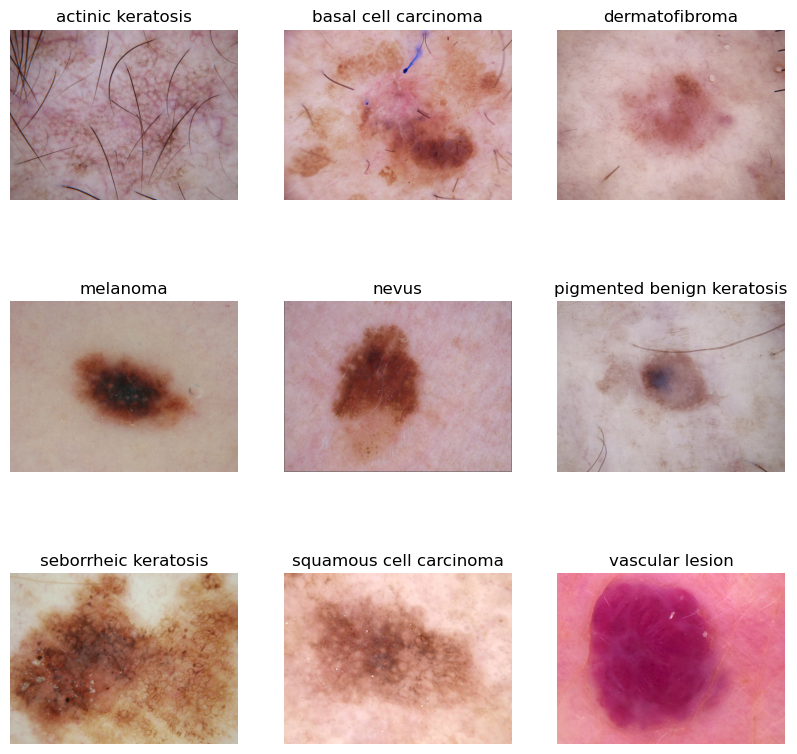

In [20]:
# code to visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [23]:
# Model-1 using original data
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling((1./255), input_shape=(img_height, img_width, 3)),  # Changed from tf.keras.layers.experimental.preprocessing.Rescaling
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9)
])

C:\Users\bagga\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model

In [26]:
# Choose an appropirate optimiser and loss function for model training
# Using ADAM optimizer and Categorical Cross Entropy as loss function
model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()     

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 732ms/step - accuracy: 0.2380 - loss: 2.1786 - val_accuracy: 0.3020 - val_loss: 1.8594
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 538ms/step - accuracy: 0.3455 - loss: 1.7931 - val_accuracy: 0.3870 - val_loss: 1.7133
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 539ms/step - accuracy: 0.4795 - loss: 1.5317 - val_accuracy: 0.5414 - val_loss: 1.4027
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 564ms/step - accuracy: 0.5231 - loss: 1.3474 - val_accuracy: 0.5101 - val_loss: 1.4639
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 539ms/step - accuracy: 0.5512 - loss: 1.3519 - val_accuracy: 0.5414 - val_loss: 1.3795
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 572ms/step - accuracy: 0.5775 - loss: 1.1888 - val_accuracy: 0.4989 - val_loss: 1.4897
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 569ms/step - accuracy: 0.5957 - loss: 1.1312 - val_accuracy: 0.4430 - val_loss: 1.6448
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 566ms/step - accuracy: 0.6191 - loss: 1.0651 - val_accu

### Visualizing training results

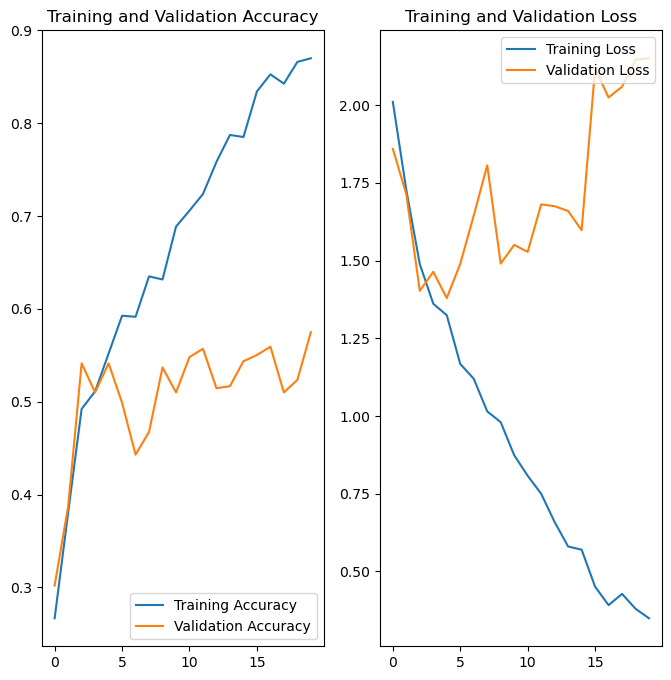

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()   

### Findings

Key Observations:
Accuracy: The training accuracy steadily increases, reaching a high value, while the validation accuracy also increases but plateaus at a lower value. This suggests that the model is overfitting.

Loss: The training loss decreases significantly, indicating that the model is learning the training data well. However, the validation loss also decreases initially but then starts to increase again. This further supports the overfitting hypothesis.

Overall, the model appears to be overfitting the training data. This means it is learning the training data too well and is not able to generalize well to new, unseen data.

In [31]:
# Since the model is overfitting, lets try augmenting the data
# Data Augmentation: Increasing the size and diversity of the training data can help the model generalize better.

rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)])

# Updated data_augmentation to use tf.keras.layers.preprocessing directly:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomTranslation(0.2, 0.2)
])

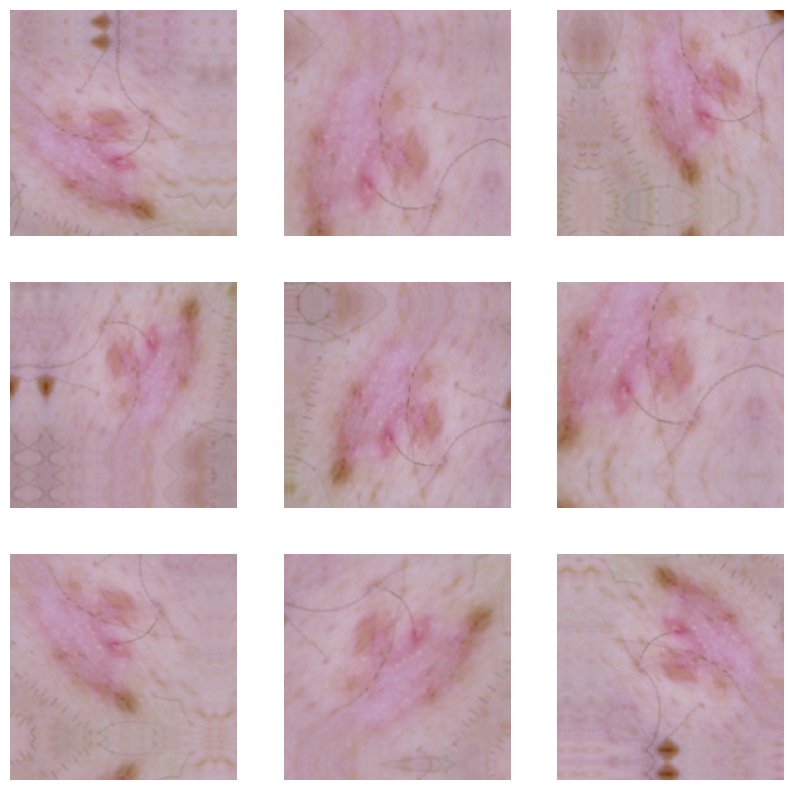

In [32]:
# Visualize how the augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Model 2: Augmented data

In [34]:
# Model-2 using the dropout layers to overcome the overfitting

# Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
# which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

model2 = Sequential([
    data_augmentation,  # Augmentation layer
    rescale,            # Rescaling layer

    # First Convolutional Block
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout with 25%

    # Second Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout with 25%

    # Third Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Flatten(),  # Flatten the tensors

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),  # Dropout with 50%

    # Output Layer
    layers.Dense(len(class_names), activation='softmax')  # Softmax for probabilities
])


### Compiling the model

In [35]:
# Using ADAM as optimizer and Categoical Cross Entropy as loss function
model2.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [36]:
## Train the model for 20 epochs
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\bagga\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 990ms/step - accuracy: 0.1655 - loss: 2.2583 - val_accuracy: 0.3199 - val_loss: 1.9506
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 935ms/step - accuracy: 0.2796 - loss: 1.9379 - val_accuracy: 0.3758 - val_loss: 1.7785
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 917ms/step - accuracy: 0.3371 - loss: 1.7806 - val_accuracy: 0.4206 - val_loss: 1.6117
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 895ms/step - accuracy: 0.4056 - loss: 1.6478 - val_accuracy: 0.4362 - val_loss: 1.7008
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 933ms/step - accuracy: 0.4145 - loss: 1.6210 - val_accuracy: 0.4183 - val_loss: 1.7204
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 873ms/step - accuracy: 0.4531 - loss: 1.5432 - val_accuracy: 0.4989 - val_loss: 1.4875
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 907ms/step - accuracy: 0.4692 - loss: 1.5000 - val_accuracy: 0.4407 - val_loss: 1.5468
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 913ms/step - accuracy: 0.4450 - loss: 1.5251 - val_accuracy: 0.472

### Visualizing the results

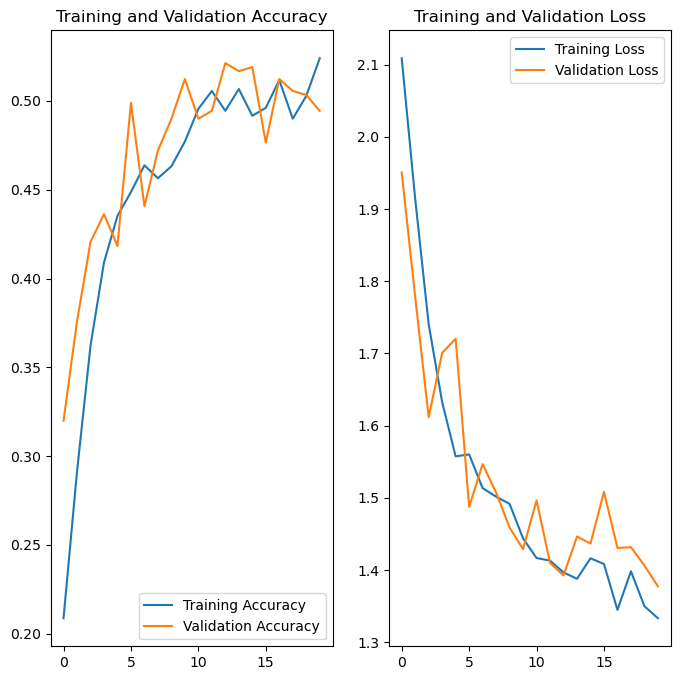

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     

#### Observations:
Accuracy:
The training and validation accuracy are steadily improving and closely aligned throughout the epochs. No significant divergence is observed, indicating no overfitting.

Loss:
Both training and validation loss decrease over the epochs and remain fairly consistent. The validation loss slightly increases toward the end, which might suggest the model is slightly overfitting as it continues to learn the training data.

#### Conclusion:
There is no clear evidence of severe overfitting or underfitting. The model is well-trained, but monitoring the slight increase in validation loss at the later epochs is recommended. Further improvements could include adding regularization techniques like dropout or early stopping to fine-tune performance.

### Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [39]:
# To find the distribution of the classes in the training data set

# Specify the directory
directory = data_dir_train

# Count the number of images in each class
count = []
for path in pathlib.Path(directory).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                          if os.path.isfile(os.path.join(path, name))]))

# Get the names of the classes (subdirectories)
sub_directory = [name for name in os.listdir(directory)
                 if os.path.isdir(os.path.join(directory, name))]

# Create a dataframe with image counts and class names
class_distribution = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Image'])

# Display the dataframe
print(class_distribution)

                        Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139


### Findings:
Class with the least number of samples:
- Seborrheic keratosis (77 samples).

Classes dominating the data (in terms of the proportionate number of samples):
- Pigmented benign keratosis (462 samples).
- Melanoma (438 samples).

### Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:
- Instantiate a Pipeline object pointing to a directory containing your initial image data set.
- Define a number of operations to perform on this data set using your Pipeline object.
- Execute these operations by calling the Pipeline’s sample() method.

In [41]:
#path_to_training_dataset = str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train / i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN images\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x16853AA1390>: 100%|██████████| 500/500 [00:34<00:00, 14.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to CNN images\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16853A55950>: 100%|██████████| 500/500 [00:28<00:00, 17.37 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to CNN images\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1684EDFF250>: 100%|██████████| 500/500 [00:28<00:00, 17.28 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to CNN images\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1684DB7A690>: 100%|██████████| 500/500 [02:14<00:00,  3.73 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to CNN images\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1684DB9B5D0>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to CNN images\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1684EDFCAD0>: 100%|██████████| 500/500 [00:18<00:00, 26.72 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to CNN images\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x16853AA3590>: 100%|██████████| 500/500 [00:43<00:00, 11.40 Samples/s]


Initialised with 181 image(s) found.
Output directory set to CNN images\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16803472910>: 100%|██████████| 500/500 [00:19<00:00, 25.85 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to CNN images\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1687E66D850>: 100%|██████████| 500/500 [00:19<00:00, 26.25 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [42]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [44]:
# Lets see the distribution of augmented data after adding new images to the original training data.

import glob
path_list = [x for x in glob.glob(os.path.join(str(data_dir_train), '*','output', '*.jpg'))] # Use glob.glob() instead of glob()
path_list

['CNN images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_029be4f4-b082-4abd-b950-1742662b83cf.jpg',
 'CNN images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4ec6df04-f7d3-41b2-9148-1d81be8caa7a.jpg',
 'CNN images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7dcad5ca-b9fd-41dd-a20f-65768461e6b8.jpg',
 'CNN images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7f948b3f-f660-468b-8496-0b2f84914f7f.jpg',
 'CNN images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_86583001-a719-4160-8c1f-ac2cad672a79.jpg',
 'CNN images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_93bc86f1-d0fa-44e8-b28a-bcaa4161fdff.jpg',
 'CNN images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_0c911a40-e48a-42b3-8a83-7df711f7eb74.jpg',
 'CNN images\\Train\\actinic keratosis\\output\\actinic

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(str(data_dir_train), '*','output', '*.jpg'))] # Use glob.glob() instead of glob()
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [46]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [47]:
original_df=pd.DataFrame(columns = ['Path','Label'])
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [48]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

In [50]:
# create training dataset
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [51]:
# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model 3: Original + Augmented data

In [52]:
# creatin the model including the normalization
# Define the Sequential model
model3 = Sequential([
    rescale,  # Rescaling Layer

    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(2, 2), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),

    # Output Layer with Softmax
    layers.Dense(len(class_names), activation='softmax')
])


### Compile your model

In [53]:
model3.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train your model

In [54]:
epochs = 30
# using 30 epochs as provided in the problem statment
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


C:\Users\bagga\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.1398 - loss: 2.6811 - val_accuracy: 0.1403 - val_loss: 3.1569
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.2707 - loss: 1.9761 - val_accuracy: 0.1507 - val_loss: 4.2819
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.3780 - loss: 1.6424 - val_accuracy: 0.1923 - val_loss: 2.9639
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.4402 - loss: 1.4803 - val_accuracy: 0.1982 - val_loss: 2.4671
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 168s 996ms/step - accuracy: 0.4634 - loss: 1.4026 - val_accuracy: 0.3534 - val_loss: 1.7179
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.5090 - loss: 1.3162 - val_accuracy: 0.2940 - val_loss: 1.9609
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 132s 526ms/step - accuracy: 0.5505 - loss: 1.2139 - val_accuracy: 0.4306 - val_loss: 1.4545
Epoch 9/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 500ms/step - accuracy: 0.5747 - loss: 1.1683 - val_accurac

### Visualize the model results

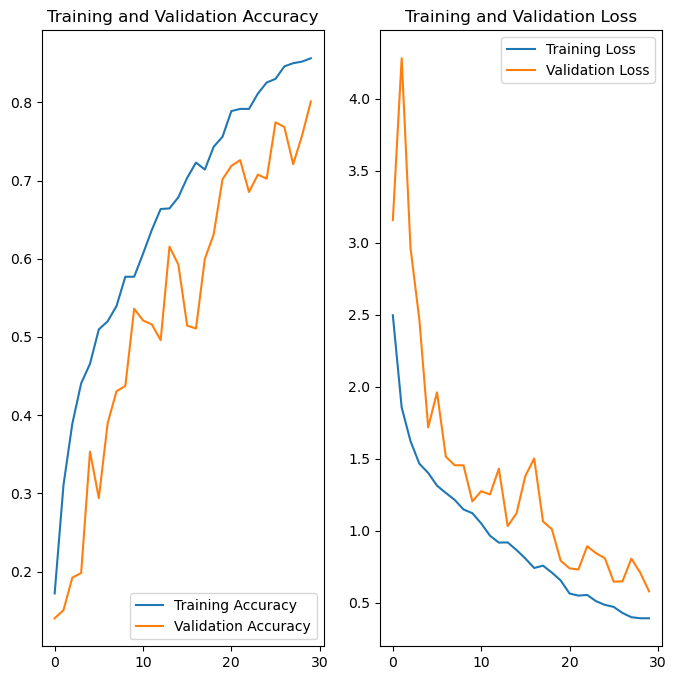

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion

After class rebalancing with augmentation, the training vs validation accuracy is closer and so is the loss